# SSD Object Detection — Oxford-IIIT Pet


- 학습에 오히려 악영향을 끼쳐, 최종 결과물에서 제외
- 트랜스폼 과정에서 파싱된 박스 정보가 오류를 발생하는 것으로 파악

In [1]:
# 표준 라이브러리
import os
import math
import random
import sys
from pathlib import Path
from glob import glob                 # 이미지 / XML 경로 수집용
import csv
import xml.etree.ElementTree as ET    # XML 어노테이션 파싱용

# 수치 연산 / 데이터 처리
import numpy as np
import pandas as pd

# 이미지 처리
import cv2
from PIL import Image

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 머신러닝 / 통계
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

# PyTorch & TorchVision
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

# Object Detection 모델 / 연산
from torchvision.models.detection import (
    ssd300_vgg16,
    fasterrcnn_resnet50_fpn,
)
from torchvision.ops import box_iou, nms          # IoU 계산, NMS
from torchvision.utils import draw_bounding_boxes # 박스 시각화

# 기타 유틸
from tqdm.auto import tqdm                        # 노트북/콘솔 공용 progress bar

# ------------------------------------------------
# (이번 미션에서는 안 쓸 가능성이 높은 import 후보)
#   필요해지면 주석 해제해서 사용
# ------------------------------------------------
# from pytorch_grad_cam import (
#     GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
#     AblationCAM, XGradCAM, EigenCAM, FullGrad,
# )
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

# 버전 출력 (환경 체크용)
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"OpenCV: {cv2.__version__}")

PyTorch: 2.9.0+cu126
NumPy: 2.0.2
Pandas: 2.2.2
OpenCV: 4.12.0


In [2]:
def get_device():
    """
    사용 가능한 연산 장치를 자동으로 탐지하여 반환하는 함수.

    동작 우선순위:
    1. CUDA GPU가 존재하면 'cuda' 장치를 반환
    2. (Mac 전용) Apple Silicon MPS 가속기가 가능하면 'mps' 장치를 반환
    3. 위 두 옵션이 모두 없을 경우 CPU 장치를 반환

    Returns:
        torch.device: 선택된 연산 장치 (cuda / mps / cpu)
    """
    # 1) CUDA (Colab or PC)
    # (코랩 설정 필요: 메뉴 - 런타임 - 런타임 유형 변경 - 하드웨어 가속기)
    if torch.cuda.is_available():
        print("CUDA GPU detected.")
        return torch.device("cuda")

    # 2) Apple Silicon (Local Mac)
    if torch.backends.mps.is_available():
        print("Apple MPS GPU detected.")
        return torch.device("mps")

    # 3) CPU fallback
    print("No GPU detected. Using CPU.")
    return torch.device("cpu")


device = get_device()
print(f"Using device: {device}")

CUDA GPU detected.
Using device: cuda


In [3]:
import logging

def init_logger():
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] (%(filename)s:%(lineno)d) - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        force=True,                 # ← Jupyter에서 강제 재설정
    )
    return logging.getLogger("pneumonia")

logger = init_logger()
logger.info("Logger initialized")

2025-12-01 04:56:10 [INFO] (ipython-input-2436937078.py:16) - Logger initialized


# 전처리/증강

	- SSD는 anchor 기반이라 작은 객체 검출에 약함 → 거의 검출 못함

① 얼굴(bbox) 기반 crop → 얼굴 비중 확대   
② aspect ratio 유지한 resize(letterbox)   
③ 기본 augmentation(Flip + 밝기/대비 조절)



In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, boxes, labels):
        for t in self.transforms:
            image, boxes, labels = t(image, boxes, labels)
        return image, boxes, labels

### 1. RandomFaceCrop

In [ ]:
import random
import torch
from PIL import Image

class RandomFaceCrop:
    """
    GT face bbox 주변을 pad_ratio 만큼 확장하여 crop.
    pad_ratio가 tuple이면 랜덤 범위에서 샘플링.
    """

    def __init__(self, pad_ratio=(0.1, 0.25)):
        if isinstance(pad_ratio, (tuple, list)):
            self.pad_min, self.pad_max = pad_ratio
        else:
            self.pad_min = self.pad_max = float(pad_ratio)

    def __call__(self, image, boxes, labels):
        """
        image: PIL.Image
        boxes: Tensor shape (N,4)
        labels: Tensor shape (N,)
        """
        # pet dataset 은 박스가 1개
        box = boxes[0]  # xmin, ymin, xmax, ymax
        xmin, ymin, xmax, ymax = box.tolist()

        W, H = image.size

        # pad_ratio 랜덤 선택
        pad_r = random.uniform(self.pad_min, self.pad_max)

        # bbox 크기
        bw = xmax - xmin
        bh = ymax - ymin

        # pad
        pad_w = bw * pad_r
        pad_h = bh * pad_r

        # 새로운 crop 영역
        new_xmin = max(0, int(xmin - pad_w))
        new_ymin = max(0, int(ymin - pad_h))
        new_xmax = min(W, int(xmax + pad_w))
        new_ymax = min(H, int(ymax + pad_h))

        # 이미지 crop
        image = image.crop((new_xmin, new_ymin, new_xmax, new_ymax))

        # 좌표 재보정
        boxes = boxes.clone()
        boxes[:, 0] -= new_xmin
        boxes[:, 1] -= new_ymin
        boxes[:, 2] -= new_xmin
        boxes[:, 3] -= new_ymin

        # 새 width, height로 clamp
        new_W = new_xmax - new_xmin
        new_H = new_ymax - new_ymin

        boxes[:, 0].clamp_(0, new_W)
        boxes[:, 1].clamp_(0, new_H)
        boxes[:, 2].clamp_(0, new_W)
        boxes[:, 3].clamp_(0, new_H)

        return image, boxes, labels

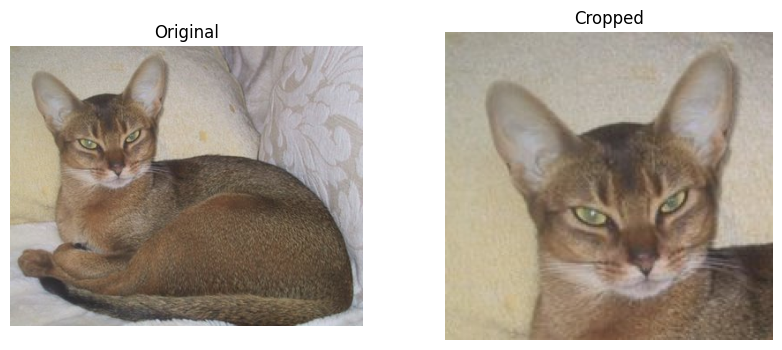

In [ ]:
def debug_crop(example_idx=0):
    img_id = df_trainval['Image'].iloc[example_idx]
    img_path = image_dir / f"{img_id}.jpg"
    xml_path = xml_dir / f"{img_id}.xml"

    # GT load
    img = Image.open(img_path).convert("RGB")
    ann = ann_by_id[img_id]          # 위에서 파싱 작업 했던 변수 재사용

    # ann["boxes"] → [{'class_name':..., 'xmin':..}]
    raw_boxes = ann["boxes"]

    # tensor boxes
    boxes = torch.tensor([
        [b["xmin"], b["ymin"], b["xmax"], b["ymax"]]
        for b in raw_boxes
    ], dtype=torch.float32)

    # species label (cat=1, dog=2)
    species = int(df_trainval.loc[df_trainval["Image"] == img_id, "Species"].iloc[0])
    labels = torch.full((boxes.shape[0],), species, dtype=torch.int64)

    # 적용
    rc = RandomFaceCrop(pad_ratio=(0.1, 0.25))
    img2, boxes2, labels2 = rc(img.copy(), boxes.clone(), labels.clone())

    # 시각화
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Cropped")
    plt.imshow(img2)
    plt.axis("off")
    plt.show()

debug_crop(11)

### 2. LetterBoxResize

In [ ]:
from PIL import Image

class LetterBoxResize:
    def __init__(self, size=300, fill=(0, 0, 0)):
        """
        size: 최종 정사각형 한 변 길이 (예: 300)
        fill: 패딩 영역 색 (RGB 튜플)
        """
        self.size = size
        self.fill = fill

    def __call__(self, image, boxes, labels):
        """
        image : PIL.Image (RGB)
        boxes : Tensor[N, 4] (xmin, ymin, xmax, ymax)
        labels: Tensor[N]
        """
        w, h = image.size
        s = self.size

        # 1) 비율 유지하면서 가장 긴 변을 s로 맞추는 scale
        scale = min(s / w, s / h)
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))

        # 2) 이미지 리사이즈
        resized = image.resize((new_w, new_h), Image.BILINEAR)

        # 3) s×s 캔버스에 가운데 배치 (레터박스)
        new_image = Image.new("RGB", (s, s), self.fill)
        left = (s - new_w) // 2
        top  = (s - new_h) // 2
        new_image.paste(resized, (left, top))

        # 4) bbox 좌표도 scale + offset 적용
        if boxes.numel() > 0:
            boxes = boxes.clone()
            # x좌표(0,2), y좌표(1,3)에 각각 scale & offset
            boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale + left
            boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale + top

        return new_image, boxes, labels

원본 size : (394, 500)
레터박스 size : (300, 300)


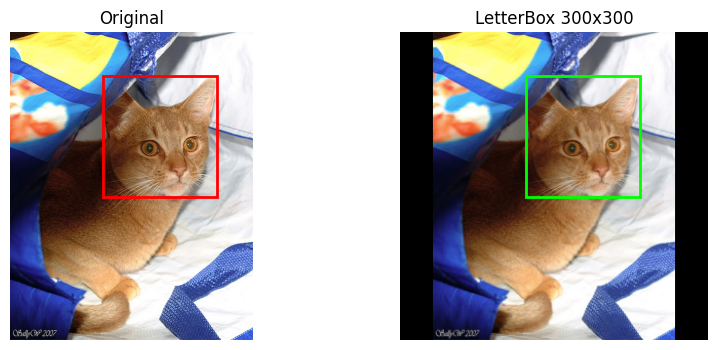

원본 size : (375, 500)
레터박스 size : (300, 300)


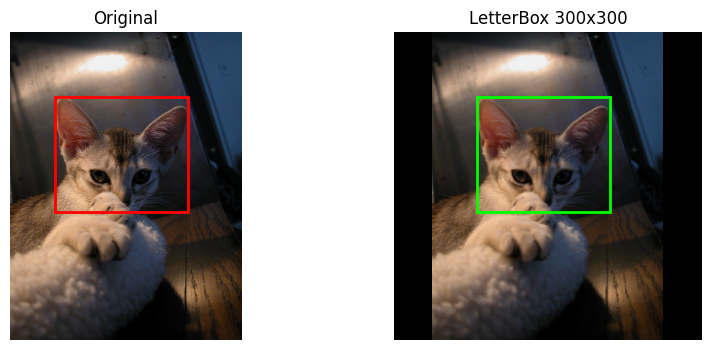

In [ ]:
import matplotlib.pyplot as plt

def debug_letterbox(example_idx=0, size=300):
    # 1) 이미지 ID / 경로
    img_id = df_trainval["Image"].iloc[example_idx]
    img_path = image_dir / f"{img_id}.jpg"
    img = Image.open(img_path).convert("RGB")

    # 2) GT boxes / labels (ann_by_id 재사용)
    ann = ann_by_id[img_id]
    raw_boxes = ann["boxes"]

    boxes = torch.tensor([
        [b["xmin"], b["ymin"], b["xmax"], b["ymax"]]
        for b in raw_boxes
    ], dtype=torch.float32)

    species = int(id_to_species[img_id])           # 1=cat, 2=dog
    labels  = torch.full((boxes.shape[0],), species, dtype=torch.int64)

    # 3) LetterBox 적용
    lb = LetterBoxResize(size=size)
    img2, boxes2, labels2 = lb(img.copy(), boxes.clone(), labels.clone())

    print("원본 size :", img.size)
    print("레터박스 size :", img2.size)

    # 4) 시각화
    plt.figure(figsize=(10, 4))

    # --- 원본 ---
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        plt.gca().add_patch(rect)
    plt.axis("off")

    # --- LetterBox ---
    plt.subplot(1, 2, 2)
    plt.title(f"LetterBox {size}x{size}")
    plt.imshow(img2)
    for box in boxes2:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="lime",
            linewidth=2,
        )
        plt.gca().add_patch(rect)
    plt.axis("off")

    plt.show()

# 예시로 몇 개 체크
debug_letterbox(0, size=300)
debug_letterbox(10, size=300)

### 3. PhotometricDistort(밝기/대비/채도/Hue)

In [ ]:
from torchvision import transforms as T
import random

class RandomPhotometricDistort:
    def __init__(
        self,
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02,
        p=0.8,        # 적용 확률 (예: 80%)
    ):
        self.jitter = T.ColorJitter(
            brightness=brightness,
            contrast=contrast,
            saturation=saturation,
            hue=hue,
        )
        self.p = p

    def __call__(self, image, boxes, labels):
        """
        image : PIL.Image (RGB)
        boxes : Tensor[N, 4]
        labels: Tensor[N]
        """
        if random.random() < self.p:
            image = self.jitter(image)   # 색만 바뀌고 bbox는 그대로

        return image, boxes, labels

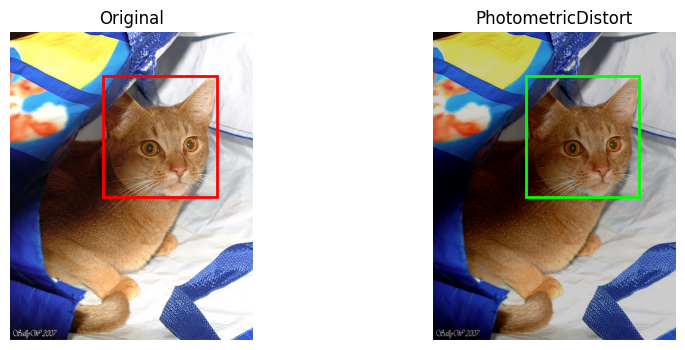

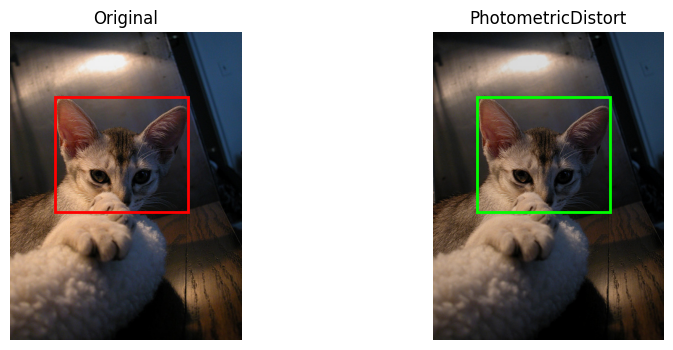

In [ ]:
def debug_Randomphotometric(example_idx=0):
    img_id = df_trainval["Image"].iloc[example_idx]
    img_path = image_dir / f"{img_id}.jpg"
    img = Image.open(img_path).convert("RGB")

    # GT boxes / labels
    ann = ann_by_id[img_id]
    raw_boxes = ann["boxes"]

    boxes = torch.tensor([
        [b["xmin"], b["ymin"], b["xmax"], b["ymax"]]
        for b in raw_boxes
    ], dtype=torch.float32)

    species = int(id_to_species[img_id])           # 1=cat, 2=dog
    labels  = torch.full((boxes.shape[0],), species, dtype=torch.int64)

    # Photometric 적용
    pdist = RandomPhotometricDistort(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.02,
        p=1.0,   # 디버그에서는 항상 적용되게 1.0으로
    )
    img2, boxes2, labels2 = pdist(img.copy(), boxes.clone(), labels.clone())

    plt.figure(figsize=(10, 4))

    # --- Original ---
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        plt.gca().add_patch(rect)
    plt.axis("off")

    # --- Photometric Distort ---
    plt.subplot(1, 2, 2)
    plt.title("PhotometricDistort")
    plt.imshow(img2)
    for box in boxes2:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="lime",
            linewidth=2,
        )
        plt.gca().add_patch(rect)
    plt.axis("off")

    plt.show()

# 몇 개 확인
debug_Randomphotometric(0)
debug_Randomphotometric(10)

### 4. RandomHorizontalFlip

In [ ]:
import random
import torch
from PIL import Image

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, boxes, labels):
        """
        image : PIL.Image
        boxes : Tensor[N, 4], (xmin, ymin, xmax, ymax)
        labels: Tensor[N]
        """

        if random.random() < self.p:
            # 1) 이미지 좌우 반전
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

            # 2) bbox 좌표도 반전
            w = image.width   # flip된 이미지 width (원본과 동일)
            boxes = boxes.clone()

            # xmin → w - xmax
            # xmax → w - xmin
            xmin = boxes[:, 0].clone()
            xmax = boxes[:, 2].clone()

            boxes[:, 0] = w - xmax
            boxes[:, 2] = w - xmin

        return image, boxes, labels

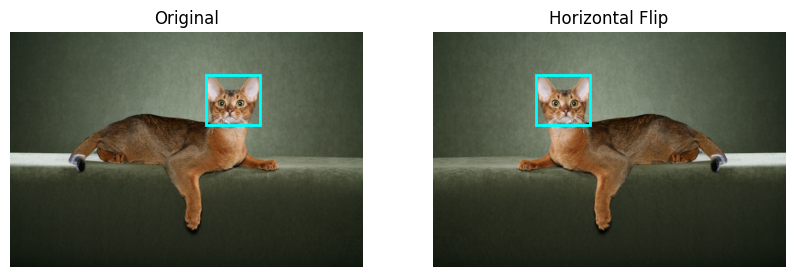

In [ ]:
def debug_hflip(example_idx=0):
    img_id = dataset.image_ids[example_idx]

    img_path = image_dir / f"{img_id}.jpg"

    # 기존 파싱 활용
    ann = ann_by_id[img_id]       # ← 여기서 bbox 구조 사용
    boxes_raw = ann["boxes"]

    boxes = []
    for b in boxes_raw:
        boxes.append([b["xmin"], b["ymin"], b["xmax"], b["ymax"]])
    boxes = torch.tensor(boxes, dtype=torch.float32)

    labels = torch.full((len(boxes),), 1, dtype=torch.int64)

    img = Image.open(img_path).convert("RGB")

    ...
    # 증강 테스트
    flip = RandomHorizontalFlip(p=1.0)   # 디버그용 → 항상 flip
    img2, boxes2, labels2 = flip(img.copy(), boxes.clone(), labels.clone())

    # 시각화 (bbox 포함)
    def show_with_boxes(ax, image, boxes, title):
        ax.imshow(image)
        for b in boxes:
            xmin, ymin, xmax, ymax = b.tolist()
            rect = plt.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                fill=False, edgecolor='cyan', linewidth=2,
            )
            ax.add_patch(rect)
        ax.set_title(title)
        ax.axis("off")

    plt.figure(figsize=(10,4))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    show_with_boxes(ax1, img, boxes, "Original")
    show_with_boxes(ax2, img2, boxes2, "Horizontal Flip")

    plt.show()

debug_hflip(0)

### 5. 전처리 적용 및 데이터셋 재정의

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, boxes, labels):
        for t in self.transforms:
            image, boxes, labels = t(image, boxes, labels)
        return image, boxes, labels

In [ ]:
from torchvision import transforms as T

# ToTensor 래퍼 (Compose 안에서 쓰기 위해)
class ToTensorTransform:
    def __call__(self, image, boxes, labels):
        image = T.ToTensor()(image)   # [3, H, W]
        return image, boxes, labels

train_transform = Compose([
    RandomFaceCrop(pad_ratio=(0.1, 0.25)),     # 얼굴 주변 crop
    LetterBoxResize(size=300),                 # SSD300용 300x300 letterbox
    RandomPhotometricDistort(p=0.8),           # 밝기/대비/색감 증강
    RandomHorizontalFlip(p=0.5),               # 좌우 반전
    ToTensorTransform(),                       # 텐서 변환
])

val_transform = Compose([
    LetterBoxResize(size=300),                 # 구조는 동일하게 300x300
    ToTensorTransform(),
])

In [ ]:
def filter_valid_boxes(boxes, labels, min_size: float = 1.0):
    """
    width, height가 min_size보다 큰 박스만 남기고 나머지는 버린다.
    boxes: Tensor[N, 4]
    labels: Tensor[N]
    """
    if boxes.numel() == 0:
        return boxes, labels

    # [xmin, ymin, xmax, ymax]
    widths  = boxes[:, 2] - boxes[:, 0]
    heights = boxes[:, 3] - boxes[:, 1]

    keep = (widths > min_size) & (heights > min_size)

    return boxes[keep], labels[keep]

In [ ]:
class PetFaceDataset(Dataset):
    def __init__(
        self,
        image_dir: Path,
        ann_by_id: dict,
        id_to_species: dict,
        image_ids=None,
        transforms=None,          # ✅ 추가
    ):
        self.image_dir = Path(image_dir)
        self.ann_by_id = ann_by_id
        self.id_to_species = id_to_species
        self.transforms = transforms   # ✅ 저장

        if image_ids is None:
            self.image_ids = sorted([
                img_id for img_id in ann_by_id.keys()
                if img_id in id_to_species
            ])
        else:
            self.image_ids = sorted([
                img_id for img_id in image_ids
                if (img_id in ann_by_id and img_id in id_to_species)
            ])

        # 기본 ToTensor는 백업용 (transform 안 쓰는 경우)
        self.to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        # 1) 이미지 로딩 (PIL)
        img_path = self.image_dir / f"{img_id}.jpg"
        image = Image.open(img_path).convert("RGB")

        # 2) 어노테이션
        ann = self.ann_by_id[img_id]
        boxes_raw = ann["boxes"]

        boxes = []
        for b in boxes_raw:
            boxes.append([b["xmin"], b["ymin"], b["xmax"], b["ymax"]])
        boxes = torch.tensor(boxes, dtype=torch.float32)  # [N, 4]

        species = int(self.id_to_species[img_id])          # 1=cat, 2=dog
        labels = torch.full((boxes.shape[0],), species, dtype=torch.int64)

        # 3) transform 적용 (Crop / Flip / Letterbox / Photometric / ToTensor)
        if self.transforms is not None:
            image, boxes, labels = self.transforms(image, boxes, labels)
        else:
            image = self.to_tensor(image)

        # 박스 오류 디버깅 추가
        boxes, labels = filter_valid_boxes(boxes, labels, min_size=1.0)


        # 4) area / iscrowd / image_id (💡 boxes 변환 후 기준으로 다시 계산)
        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": areas,
            "iscrowd": iscrowd,
            "image_id": image_id,
        }

        return image, target

In [ ]:
# 기존에 만들었던 train_ids, val_ids 재사용

train_dataset = PetFaceDataset(
    image_dir=image_dir,
    ann_by_id=ann_by_id,
    id_to_species=id_to_species,
    image_ids=train_ids,
    transforms=train_transform,   # ✅ train 전용 transform
)

val_dataset = PetFaceDataset(
    image_dir=image_dir,
    ann_by_id=ann_by_id,
    id_to_species=id_to_species,
    image_ids=val_ids,
    transforms=val_transform,     # ✅ val 전용 transform
)

print("Train dataset 길이:", len(train_dataset))
print("Val dataset 길이  :", len(val_dataset))

BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=detection_collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=detection_collate_fn,
)

# 간단 sanity check
images, targets = next(iter(train_loader))
print("배치 이미지 개수:", len(images))
print("첫 번째 이미지 shape:", images[0].shape)       # [3, 300, 300] 기대
print("첫 번째 타깃 boxes shape:", targets[0]["boxes"].shape)
print("첫 번째 타깃 labels:", targets[0]["labels"])

Train dataset 길이: 2937
Val dataset 길이  : 734
배치 이미지 개수: 8
첫 번째 이미지 shape: torch.Size([3, 300, 300])
첫 번째 타깃 boxes shape: torch.Size([1, 4])
첫 번째 타깃 labels: tensor([2])


In [ ]:
# 데이터셋 확인
def show_sample_from_loader(loader, title="Sample"):
    images, targets = next(iter(loader))

    img_t  = images[0]             # Tensor [3, H, W]
    target = targets[0]

    # 이미지 변환
    img_np = img_t.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)

    boxes  = target["boxes"].numpy()
    labels = target["labels"].numpy()

    plt.figure(figsize=(5, 5))
    plt.imshow(img_np)

    for box, lab in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box

        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="lime",
            linewidth=2,
        )
        plt.gca().add_patch(rect)

        cls_name = "cat" if int(lab) == 1 else "dog"
        plt.text(
            xmin,
            ymin - 5,
            cls_name,
            color="white",
            fontsize=8,
            bbox=dict(facecolor="green", alpha=0.5)
        )

    plt.title(title)
    plt.axis("off")
    plt.show()

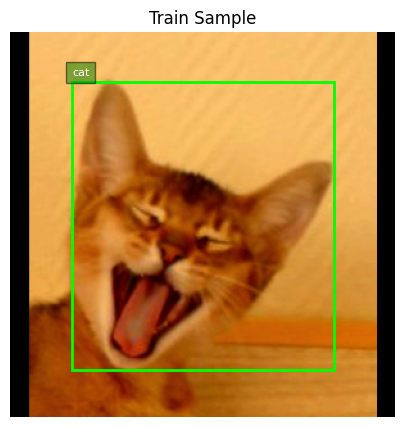

In [ ]:
show_sample_from_loader(train_loader, "Train Sample")

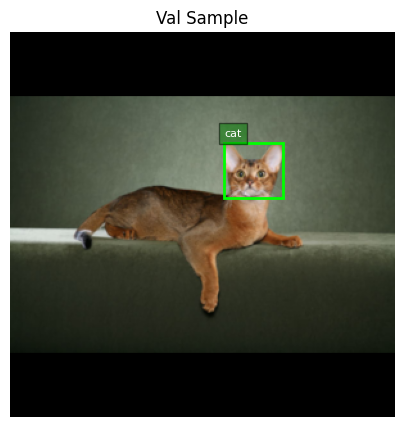

In [ ]:
show_sample_from_loader(val_loader, "Val Sample")